# ML Pipeline for Error Type Classification (Random Forest vs XGBoost)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from xgboost import XGBClassifier

## Load and Merge Datasets

In [2]:
# Load datasets
machine_df = pd.read_csv("Machine_Settings_Log_01.csv")
production_df = pd.read_csv("Production_Log_01.csv")

# Merge datasets
full_df = production_df.merge(machine_df, on="configuration_log_ID")

## Feature Selection and Encoding

In [3]:
# Pre-machine input features
features = [
    'width', 'height', 'ionizationclass', 'FluxCompensation',
    'pressure', 'karma', 'modulation', 'gear', 'rotation_speed'
]
X = full_df[features].copy()
y_raw = full_df['error_type'].copy()

# Encode categorical features
le_ion = LabelEncoder()
le_flux = LabelEncoder()
X['ionizationclass'] = le_ion.fit_transform(X['ionizationclass'])
X['FluxCompensation'] = le_flux.fit_transform(X['FluxCompensation'])

## Filter Error Records and Encode Labels

In [4]:
# Filter only error records
y_error = y_raw[y_raw.isin(['critical', 'minor', 'severe'])]
X_error = X.loc[y_error.index]

# Encode labels ONCE for consistency
label_encoder = LabelEncoder()
label_encoder.fit(['critical', 'minor', 'severe'])

X_train, X_test, y_train_raw, y_test_raw = train_test_split(X_error, y_error, test_size=0.2, random_state=42, stratify=y_error)
y_train = label_encoder.transform(y_train_raw)
y_test = label_encoder.transform(y_test_raw)

## Train Random Forest and XGBoost Models

In [5]:
# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)

# Train XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
acc_xgb = accuracy_score(y_test, y_pred_xgb)

print("Random Forest Accuracy:", acc_rf)
print("XGBoost Accuracy:", acc_xgb)

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:46:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1745056743506/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Random Forest Accuracy: 0.36701337295690933
XGBoost Accuracy: 0.3536404160475483


## Classification Report Heatmaps

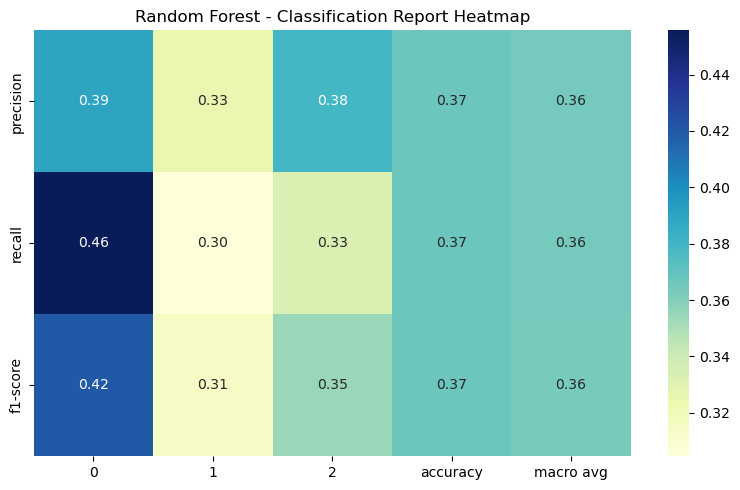

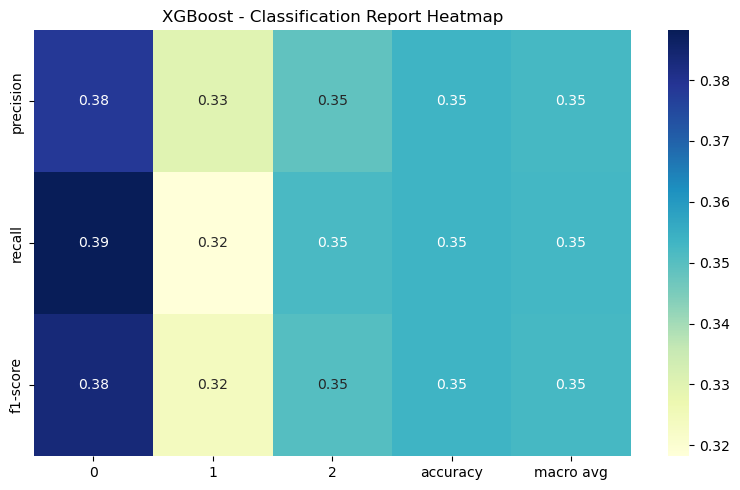

In [6]:
def plot_report_heatmap(y_true, y_pred, model_name):
    report = classification_report(y_true, y_pred, output_dict=True)
    df = pd.DataFrame(report).iloc[:-1, :-1]
    plt.figure(figsize=(8, 5))
    sns.heatmap(df, annot=True, cmap='YlGnBu', fmt=".2f")
    plt.title(f"{model_name} - Classification Report Heatmap")
    plt.tight_layout()
    plt.show()

plot_report_heatmap(y_test, y_pred_rf, "Random Forest")
plot_report_heatmap(y_test, y_pred_xgb, "XGBoost")

## Feature Importance

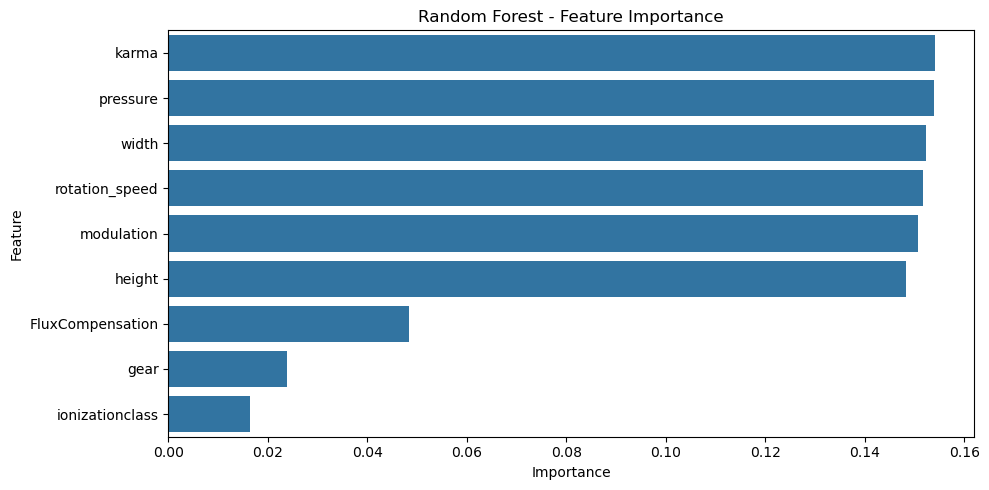

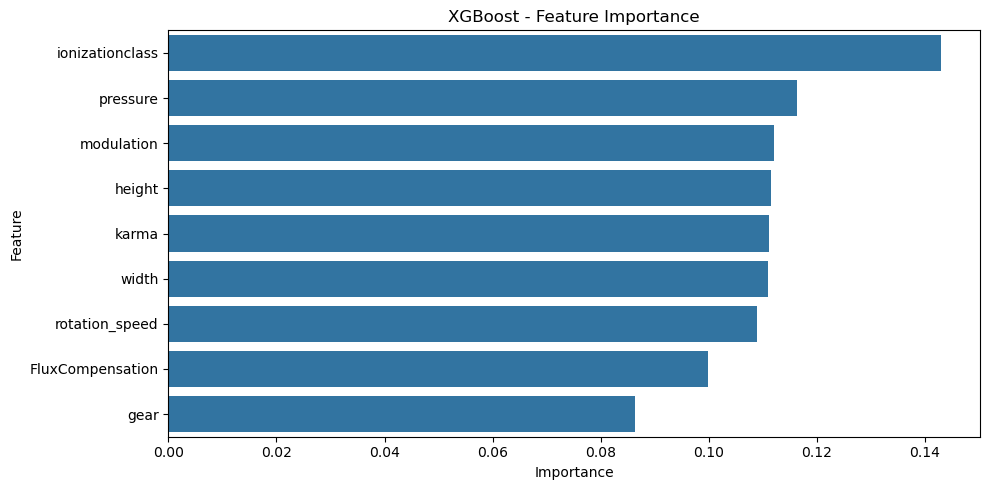

In [7]:
def plot_feature_importance(importances, features, model_name):
    feat_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)
    plt.figure(figsize=(10, 5))
    sns.barplot(data=feat_df, x='Importance', y='Feature')
    plt.title(f"{model_name} - Feature Importance")
    plt.tight_layout()
    plt.show()

plot_feature_importance(rf_model.feature_importances_, X.columns, "Random Forest")
plot_feature_importance(xgb_model.feature_importances_, X.columns, "XGBoost")

## Multiclass ROC Curve

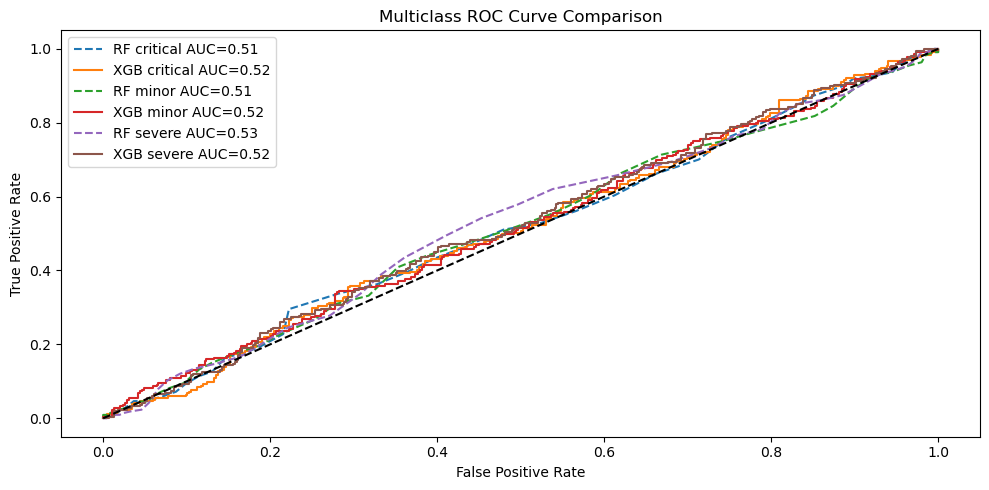

In [8]:
classes = label_encoder.classes_
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_score_rf = rf_model.predict_proba(X_test)
y_score_xgb = xgb_model.predict_proba(X_test)

plt.figure(figsize=(10, 5))
for i in range(len(classes)):
    fpr_rf, tpr_rf, _ = roc_curve(y_test_bin[:, i], y_score_rf[:, i])
    fpr_xgb, tpr_xgb, _ = roc_curve(y_test_bin[:, i], y_score_xgb[:, i])
    plt.plot(fpr_rf, tpr_rf, linestyle='--', label=f"RF {classes[i]} AUC={auc(fpr_rf, tpr_rf):.2f}")
    plt.plot(fpr_xgb, tpr_xgb, linestyle='-', label=f"XGB {classes[i]} AUC={auc(fpr_xgb, tpr_xgb):.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve Comparison")
plt.legend()
plt.tight_layout()
plt.show()

## XGBoost Learning Curve

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:46:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1745056743506/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:46:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1745056743506/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:46:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1745056743506/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:46:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboo

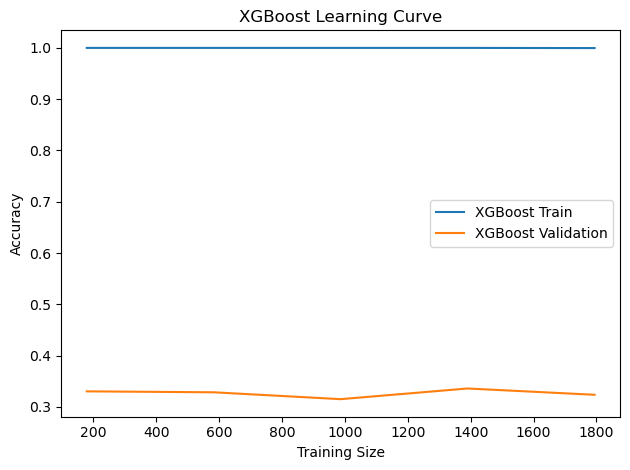

In [9]:
train_sizes, train_scores, test_scores = learning_curve(xgb_model, X_train, y_train, cv=3, scoring='accuracy')
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, label='XGBoost Train')
plt.plot(train_sizes, test_scores_mean, label='XGBoost Validation')
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.title("XGBoost Learning Curve")
plt.legend()
plt.tight_layout()
plt.show()

## XGBoost Prediction Distribution

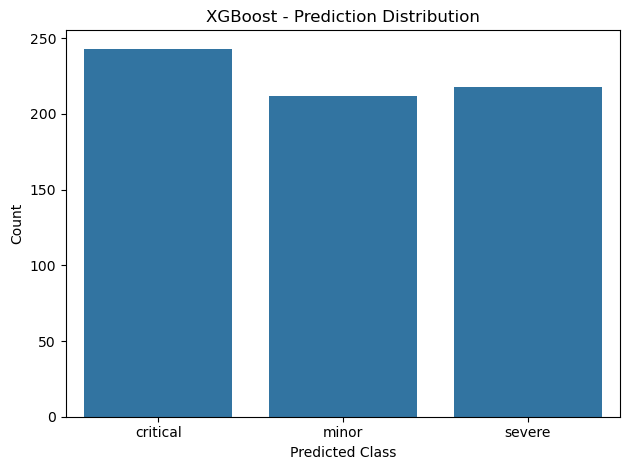

In [10]:
plt.figure()
sns.countplot(x=label_encoder.inverse_transform(y_pred_xgb), order=classes)
plt.title("XGBoost - Prediction Distribution")
plt.xlabel("Predicted Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

## Accuracy Summary

In [11]:
print(f"\nModel Comparison Summary:\nRandom Forest Accuracy: {acc_rf:.4f}\nXGBoost Accuracy: {acc_xgb:.4f}")


Model Comparison Summary:
Random Forest Accuracy: 0.3670
XGBoost Accuracy: 0.3536
